# Verify performance of OSD and compare against other ML solutions

This notebook includes benchmarks of OSD against other known ML decoders.

In [2]:
num_GPU = 1
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.15.0
Only GPU number 1 used


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sys
sys.path.append('../../..')
import sionna
%reload_ext autoreload
%autoreload 2
import importlib
importlib.reload(sionna)

# Load Sionna components
from sionna.phy.mapping import Mapper, Demapper, Constellation
from sionna.phy.utils import BinarySource, ebnodb2no, hard_decisions, PlotBER
from sionna.phy.channel import AWGN
from sionna.phy.fec.utils import load_parity_check_examples

from sionna.phy.fec.linear import LinearEncoder, OSDecoder
from sionna.phy.fec.polar import PolarEncoder, PolarSCLDecoder, generate_5g_ranking
from sionna.phy.fec.conv import ConvEncoder, ViterbiDecoder


## Define System Model

In [4]:
class System_Model(tf.keras.Model):
    """System model for channel coding BER simulations.

    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. Arbitrary FEC encoder/decoder layers can be used to
    initialize the model.

    Parameters
    ----------
        encoder: Keras layer
            A Keras layer that encodes information bit tensors.

        decoder: Keras layer
            A Keras layer that decodes llr tensors.

        cw_estimate: bool
            Defaults to True. If True the decoder outputs codeword estimates instead of information estimates.

    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.

        ebno_db: float or tf.float
            A float defining the simulation SNR.

    Output
    ------
        (u, u_hat):
            Tuple:

        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.
    """
    def __init__(self,
                 encoder,
                 decoder,
                 cw_estimate=True):

        super().__init__()

        # store values internally
        self.k = encoder.k
        self.n = encoder.n

        self._cw_estimate = cw_estimate

        # number of bit per QAM symbol
        # use pam as no additional filler bits are required for odd length
        self.num_bits_per_symbol = 1

        # initialize mapper and demapper
        self.mapper = Mapper("pam", 1)
        self.demapper = Demapper("app", "pam", 1)

        # init components
        self.source = BinarySource()

        # the channel can be replaced by more sophisticated models
        self.channel = AWGN()

        # FEC encoder / decoder
        self.encoder = encoder
        self.decoder = decoder

    @tf.function(jit_compile=True) # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):

        no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=self.num_bits_per_symbol,
                       coderate=self.k/self.n)

        u = self.source([batch_size, self.k]) # generate random data
        #u = tf.zeros_like(u)
        c = self.encoder(u) # explicitly encode

        x = self.mapper(c) # map c to symbols x
        y = self.channel(x, no) # transmit over AWGN channel
        llr_ch = self.demapper(y, no) # demap y to LLRs

        # and run the decoder
        c_hat = self.decoder(llr_ch)

        #c_hat = hard_decisions(llr_ch)

        if self._cw_estimate:
            return c, c_hat
        else:
            return u, c_hat

## Evaluate (7,4) Hamming

2024-11-27 11:18:37.920330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 11:18:37.922228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 11:18:37.923998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 8.1631e-02 | 1.7767e-01 |        6857 |       84000 |         2132 |       12000 |         3.0 |reached target block errors
      1.0 | 5.1198e-02 | 1.1206e-01 |        6451 |      126000 |         2017 |       18000 |         0.1 |reached target block errors
      2.0 | 2.9076e-02 | 6.4406e-02 |        6513 |      224000 |         2061 |       32000 |         0.2 |reached target block errors
      3.0 | 1.3686e-02 | 3.0318e-02 |        6323 |      462000 |         2001 |       66000 |         0.4 |reached target block errors
      4.0 | 5.4971e-03 | 1.2370e-02 |        3848 |      700000 |         1237 |      100000 |         0.6 |reached max iterations
      5.0 | 1.6086e-03 | 3.6300e-03 |        1126 |      700000 |     

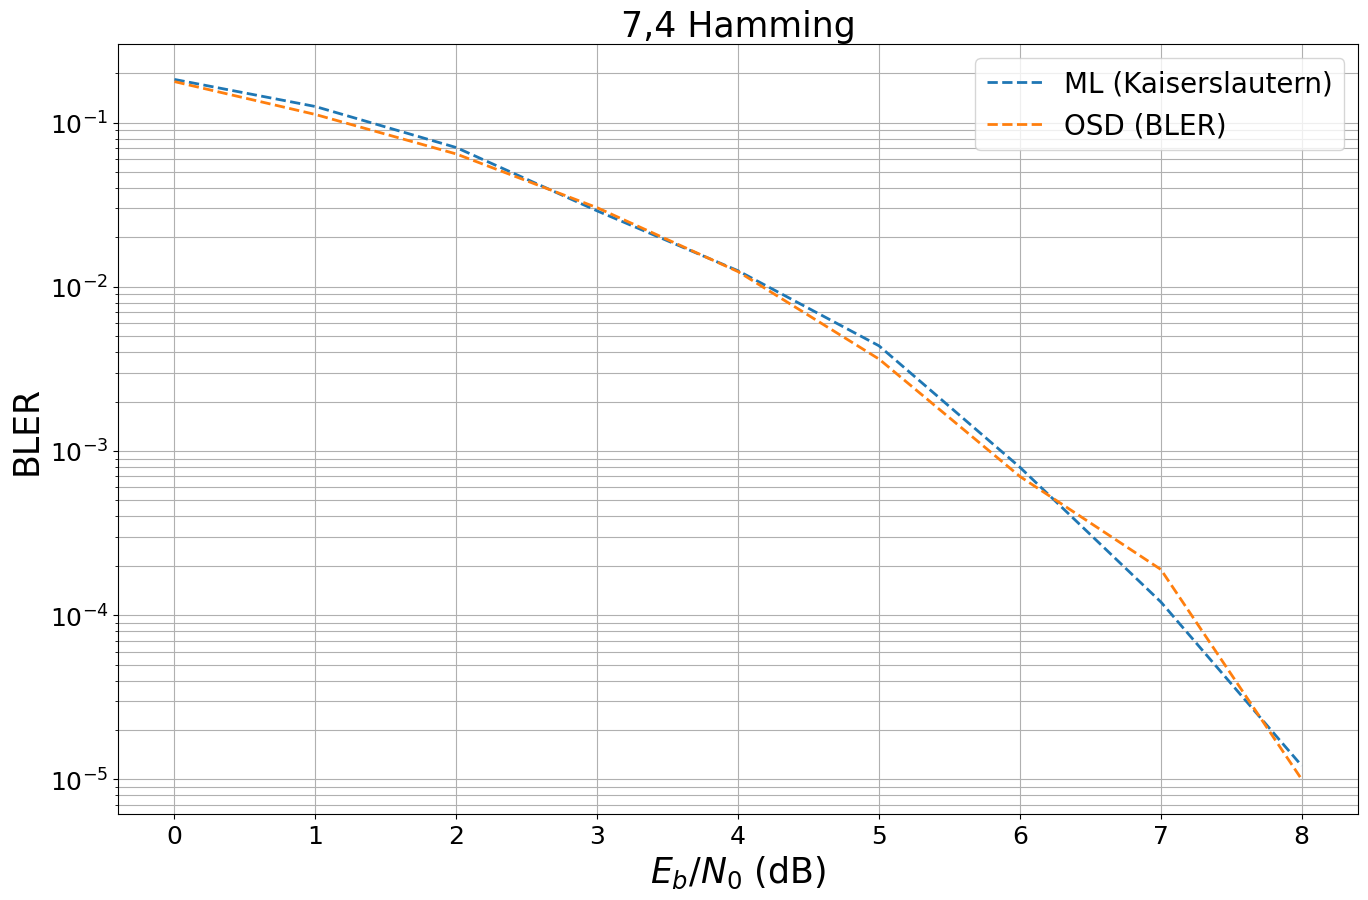

In [5]:
ebno_db = np.linspace(0, 8, 9) # sim SNR range
id = 0 # 7,4 Hamming
pcm, k, n, coderate = load_parity_check_examples(id, verbose=False)

# init components
enc = LinearEncoder(pcm, is_pcm=True)
#dec = OSDecoder(pcm, is_pcm=True, t=2)
dec = OSDecoder(encoder=enc, t=2)
model = System_Model(enc, dec, cw_estimate=True)

# and run simulation
ber_plot = PlotBER(f"7,4 Hamming")

# add TU KL reference curves
# https://www.uni-kl.de/fileadmin/chaco/public/results_bch/BCH_N7_K4_ML.txt
snrs_ref = np.linspace(0, 8, 9)
blers_ref = np.array([1.832e-01, 1.253e-01, 7.047e-02, 2.899e-02, 1.252e-02, 4.371e-03, 7.962e-04, 1.205e-04, 1.211e-05])
ber_plot.add(snrs_ref, blers_ref, is_bler=True, legend="ML (Kaiserslautern)")

ber_plot.simulate(model,
                  ebno_dbs=ebno_db,
                  legend="OSD",
                  max_mc_iter=100,
                  num_target_block_errors=2000,
                  batch_size=1000,
                  soft_estimates=False,
                  early_stop=True,
                  show_fig=False,
                  add_bler=True,
                  forward_keyboard_interrupt=True);

ber_plot(show_ber=False)

## Evaluate (63,45) BCH


n: 63, k: 45, coderate: 0.714


2024-11-27 11:18:46.906426: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal/Assert/Assert
2024-11-27 11:18:46.906509: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal/Assert/Assert
2024-11-27 11:18:46.906644: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_1/Assert/Assert
2024-11-27 11:18:46.906865: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal_1/Assert/Assert
2024-11-27 11:18:46.906922: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_2/Assert/Assert
2024-11-27 11:18:47.698667: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_118', 4 bytes spill stores, 4 bytes spill loads

2024-11-27 11:18:47.760956: I external/local_xla/xla/stream_exec

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.1614e-01 | 7.1367e-01 |       21951 |      189000 |         2141 |        3000 |         2.4 |reached target block errors
      0.5 | 9.1155e-02 | 5.7625e-01 |       22971 |      252000 |         2305 |        4000 |         0.0 |reached target block errors
      1.0 | 6.4930e-02 | 4.2200e-01 |       20453 |      315000 |         2110 |        5000 |         0.0 |reached target block errors
      1.5 | 3.9579e-02 | 2.6687e-01 |       19948 |      504000 |         2135 |        8000 |         0.1 |reached target block errors
      2.0 | 2.1488e-02 | 1.4893e-01 |       18952 |      882000 |         2085 |       14000 |         0.1 |reached target block errors
      2.5 | 9.2867e-03 | 6.6387e-02 |       18137 |     1953000 |

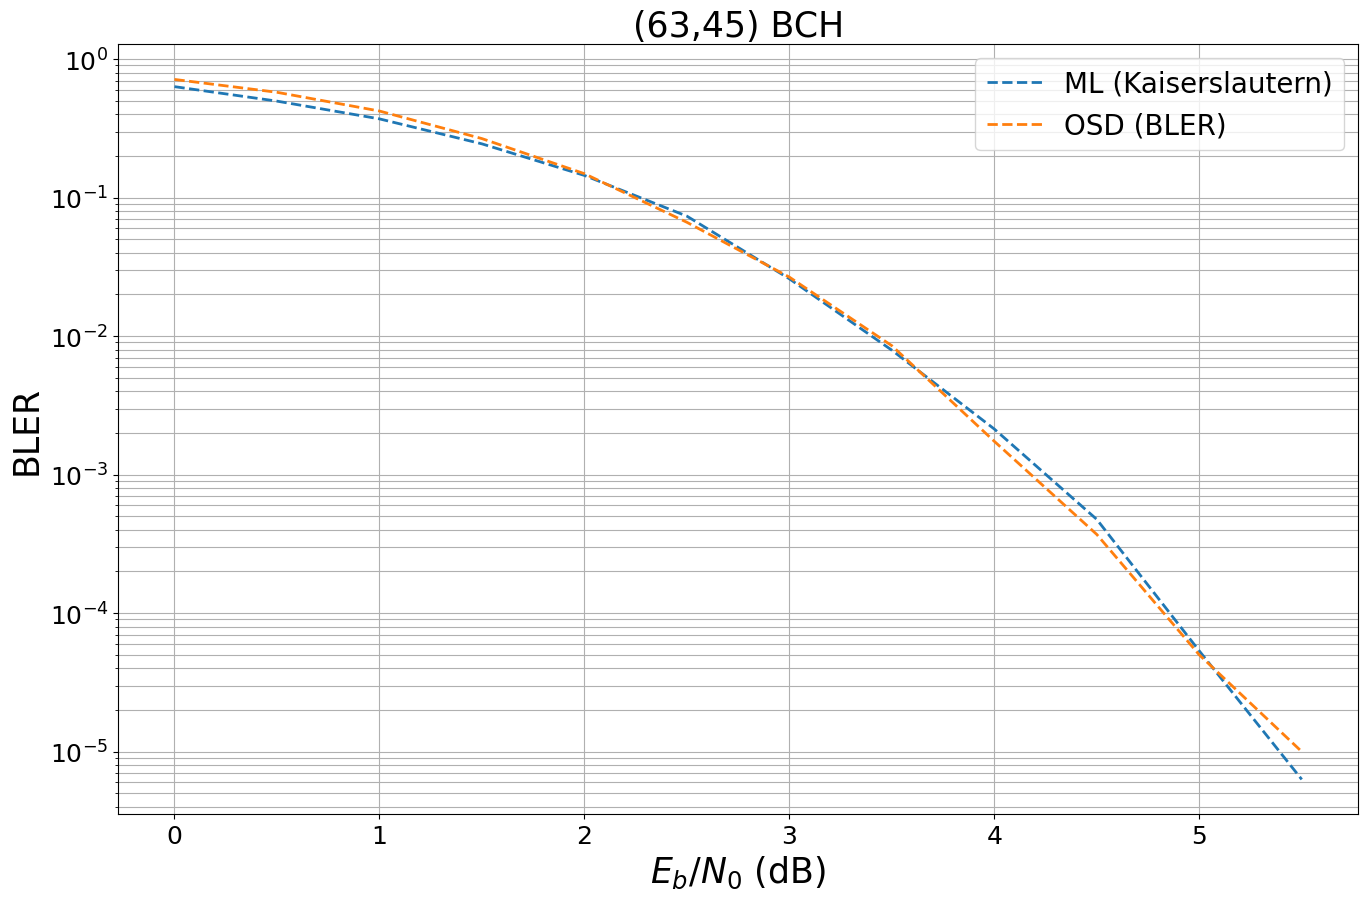

In [6]:
ebno_db = np.linspace(0, 5.5, 12) # sim SNR range
id = 1 # 63,45 BCH
pcm, k, n, coderate = load_parity_check_examples(id, verbose=True)

# init components
enc = LinearEncoder(pcm, is_pcm=True)
dec = OSDecoder(encoder=enc, t=2, dtype=tf.float32)
model = System_Model(enc, dec, cw_estimate=True)

# and run simulation
ber_plot = PlotBER(f"(63,45) BCH")

# add TU KL reference curves
# https://www.uni-kl.de/fileadmin/chaco/public/results_bch/BCH_N63_K45_ML.txt
snrs_ref = np.linspace(0,5.5,12)
blers_ref = np.array([6.329e-01,4.975e-01,3.704e-01, 2.445e-01, 1.447e-01, 7.353e-02,2.595e-02, 7.918e-03, 2.134e-03,4.751e-04,5.337e-05,6.300e-06])
ber_plot.add(snrs_ref, blers_ref, is_bler=True, legend="ML (Kaiserslautern)")

ber_plot.simulate(model,
                  ebno_dbs=ebno_db,
                  legend="OSD",
                  max_mc_iter=100,
                  num_target_block_errors=2000,
                  batch_size=1000,
                  soft_estimates=False,
                  early_stop=True,
                  show_fig=False,
                  add_bler=True,
                  forward_keyboard_interrupt=True);

ber_plot(show_ber=False)

## Evaluate Polar & SCL

Note: Required memory complexity is large for the given code parameters and t=4. Please consider small batch-sizes to keep the inference complexity small and activate XLA mode if possible.


2024-11-27 11:19:08.671147: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal/Assert/Assert
2024-11-27 11:19:08.671260: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal/Assert/Assert
2024-11-27 11:19:08.671401: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_1/Assert/Assert
2024-11-27 11:19:08.671674: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal_1/Assert/Assert
2024-11-27 11:19:08.671745: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_2/Assert/Assert


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.7426e-01 | 7.6200e-01 |       65823 |      240000 |         2286 |        3000 |        42.1 |reached target block errors
      1.0 | 1.1773e-01 | 3.9983e-01 |       56509 |      480000 |         2399 |        6000 |         1.3 |reached target block errors
      2.0 | 2.4968e-02 | 1.0789e-01 |       37952 |     1520000 |         2050 |       19000 |         4.0 |reached target block errors
      3.0 | 2.8929e-03 | 1.5230e-02 |       23143 |     8000000 |         1523 |      100000 |        21.1 |reached max iterations
      4.0 | 1.8038e-04 | 1.0900e-03 |        1443 |     8000000 |          109 |      100000 |        21.0 |reached max iterations
      5.0 | 3.0000e-06 | 3.0000e-05 |          24 |     8000000 |          

2024-11-27 11:21:07.080496: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal/Assert/Assert
2024-11-27 11:21:07.080596: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal/Assert/Assert
2024-11-27 11:21:07.080748: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_1/Assert/Assert
2024-11-27 11:21:07.080998: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal_1/Assert/Assert
2024-11-27 11:21:07.081051: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_2/Assert/Assert


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.8842e-01 | 9.5857e-01 |       50646 |      268800 |         2013 |        2100 |         1.3 |reached target block errors
      1.0 | 1.4783e-01 | 8.3480e-01 |       47304 |      320000 |         2087 |        2500 |         0.2 |reached target block errors
      2.0 | 8.7563e-02 | 5.5270e-01 |       41470 |      473600 |         2045 |        3700 |         0.3 |reached target block errors
      3.0 | 4.0340e-02 | 2.6693e-01 |       38726 |      960000 |         2002 |        7500 |         0.6 |reached target block errors
      4.0 | 1.2781e-02 | 8.7500e-02 |       16360 |     1280000 |          875 |       10000 |         0.8 |reached max iterations
      5.0 | 2.9594e-03 | 2.0000e-02 |        3788 |     1280000 |     

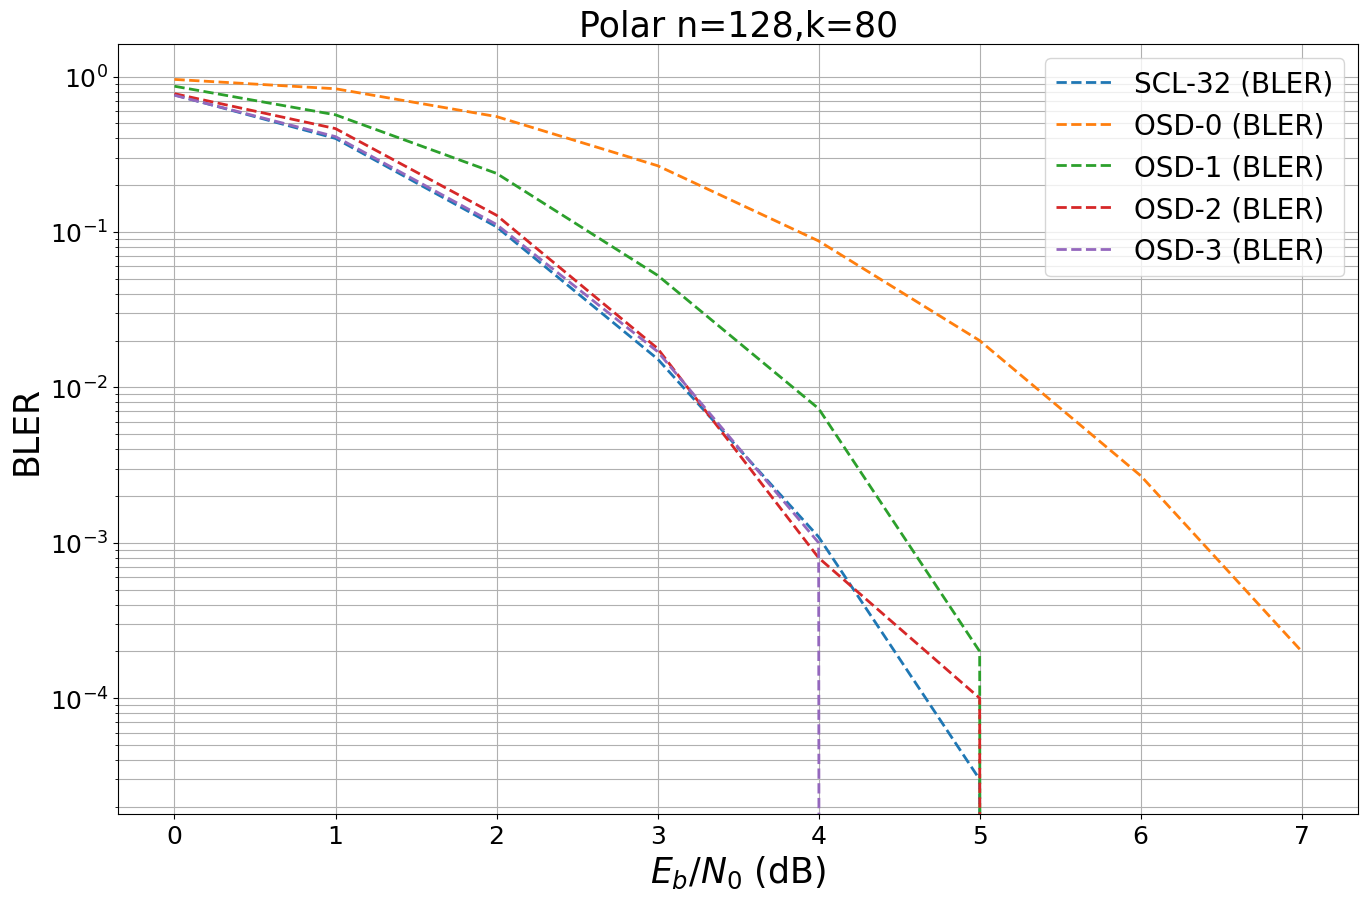

In [7]:
ebno_db = np.linspace(0, 7, 8) # sim SNR range

k = 80
n = 128
f, _ = generate_5g_ranking(k, n)
# init components
enc = PolarEncoder(f, n)
dec = OSDecoder(encoder=enc, t=4)
model = System_Model(enc, dec, cw_estimate=True)

dec_ref = PolarSCLDecoder(f, n, list_size=32)
model_ref = System_Model(enc, dec_ref, cw_estimate=False)


# and run simulation
ber_plot = PlotBER(f"Polar n={n},k={k}")

# reference with Polar SCL
ber_plot.simulate(model_ref,
                  ebno_dbs=ebno_db,
                  legend=f"SCL-{dec_ref.list_size}",
                  max_mc_iter=100,
                  num_target_block_errors=2000,
                  batch_size=1000,
                  soft_estimates=False,
                  early_stop=True,
                  show_fig=False,
                  add_bler=True,
                  forward_keyboard_interrupt=True);

# sweep over t
for t in range(4):
    dec = OSDecoder(encoder=enc, t=t)
    model = System_Model(enc, dec, cw_estimate=True)
    ber_plot.simulate(model,
                    ebno_dbs=ebno_db,
                    legend=f"OSD-{dec.t}",
                    max_mc_iter=100,
                    num_target_block_errors=2000,
                    batch_size=100,
                    soft_estimates=False,
                    early_stop=True,
                    show_fig=False,
                    add_bler=True,
                    forward_keyboard_interrupt=True);


# ber is not comparable (u_hat vs. c_hat)
ber_plot(show_ber=False)


**Remark**: SCL-32 is not necessarily optimal for longer codes.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.3316e-01 | 3.1314e-01 |       14914 |      112000 |         2192 |        7000 |         7.9 |reached target block errors
      1.0 | 6.1902e-02 | 1.5286e-01 |       13866 |      224000 |         2140 |       14000 |         0.2 |reached target block errors
      2.0 | 2.3384e-02 | 5.6611e-02 |       13469 |      576000 |         2038 |       36000 |         0.8 |reached target block errors
      3.0 | 5.4800e-03 | 1.3710e-02 |        8768 |     1600000 |         1371 |      100000 |         2.2 |reached max iterations
      4.0 | 7.6687e-04 | 1.8600e-03 |        1227 |     1600000 |          186 |      100000 |         2.2 |reached max iterations
      5.0 | 5.6875e-05 | 1.6000e-04 |          91 |     1600000 |          

2024-11-27 11:22:04.844942: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_37', 24 bytes spill stores, 20 bytes spill loads



EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.5669e-01 | 5.2875e-01 |       20056 |      128000 |         2115 |        4000 |         0.9 |reached target block errors
      1.0 | 1.0354e-01 | 3.6100e-01 |       19880 |      192000 |         2166 |        6000 |         0.0 |reached target block errors
      2.0 | 5.6443e-02 | 1.9809e-01 |       19868 |      352000 |         2179 |       11000 |         0.1 |reached target block errors
      3.0 | 2.6267e-02 | 9.3727e-02 |       18492 |      704000 |         2062 |       22000 |         0.1 |reached target block errors
      4.0 | 9.6401e-03 | 3.4672e-02 |       17892 |     1856000 |         2011 |       58000 |         0.4 |reached target block errors
      5.0 | 2.8075e-03 | 1.0060e-02 |        8984 |     3200000 |

2024-11-27 11:22:08.540031: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_47', 24 bytes spill stores, 20 bytes spill loads



EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 9.0696e-02 | 3.2414e-01 |       20316 |      224000 |         2269 |        7000 |         1.1 |reached target block errors
      1.0 | 4.3635e-02 | 1.6262e-01 |       18152 |      416000 |         2114 |       13000 |         0.1 |reached target block errors
      2.0 | 1.6691e-02 | 6.2875e-02 |       17092 |     1024000 |         2012 |       32000 |         0.2 |reached target block errors
      3.0 | 4.1575e-03 | 1.6050e-02 |       13304 |     3200000 |         1605 |      100000 |         0.7 |reached max iterations
      4.0 | 5.9250e-04 | 2.3400e-03 |        1896 |     3200000 |          234 |      100000 |         0.7 |reached max iterations
      5.0 | 5.0000e-05 | 2.0000e-04 |         160 |     3200000 |          

2024-11-27 11:22:12.706724: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_52', 24 bytes spill stores, 20 bytes spill loads



EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 8.5786e-02 | 3.0900e-01 |       19216 |      224000 |         2163 |        7000 |         1.2 |reached target block errors
      1.0 | 4.1885e-02 | 1.5485e-01 |       17424 |      416000 |         2013 |       13000 |         0.1 |reached target block errors
      2.0 | 1.4851e-02 | 5.6278e-02 |       17108 |     1152000 |         2026 |       36000 |         0.3 |reached target block errors
      3.0 | 3.6625e-03 | 1.4220e-02 |       11720 |     3200000 |         1422 |      100000 |         0.7 |reached max iterations
      4.0 | 4.2750e-04 | 1.6800e-03 |        1368 |     3200000 |          168 |      100000 |         0.7 |reached max iterations
      5.0 | 2.5000e-05 | 1.0000e-04 |          80 |     3200000 |          

2024-11-27 11:22:17.747384: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_57', 24 bytes spill stores, 20 bytes spill loads



EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 8.7679e-02 | 3.1771e-01 |       19640 |      224000 |         2224 |        7000 |         1.2 |reached target block errors
      1.0 | 4.1615e-02 | 1.5408e-01 |       17312 |      416000 |         2003 |       13000 |         0.1 |reached target block errors
      2.0 | 1.4764e-02 | 5.6000e-02 |       17008 |     1152000 |         2016 |       36000 |         0.2 |reached target block errors
      3.0 | 3.4487e-03 | 1.3360e-02 |       11036 |     3200000 |         1336 |      100000 |         0.7 |reached max iterations
      4.0 | 4.6625e-04 | 1.8200e-03 |        1492 |     3200000 |          182 |      100000 |         0.7 |reached max iterations
      5.0 | 3.1250e-05 | 1.2000e-04 |         100 |     3200000 |          

2024-11-27 11:22:22.101912: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_62', 24 bytes spill stores, 20 bytes spill loads



EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 8.8929e-02 | 3.2071e-01 |       19920 |      224000 |         2245 |        7000 |         1.4 |reached target block errors
      1.0 | 4.2990e-02 | 1.5923e-01 |       17884 |      416000 |         2070 |       13000 |         0.1 |reached target block errors
      2.0 | 1.5017e-02 | 5.7000e-02 |       17300 |     1152000 |         2052 |       36000 |         0.3 |reached target block errors
      3.0 | 3.4412e-03 | 1.3330e-02 |       11012 |     3200000 |         1333 |      100000 |         0.8 |reached max iterations
      4.0 | 5.4000e-04 | 2.1100e-03 |        1728 |     3200000 |          211 |      100000 |         0.8 |reached max iterations
      5.0 | 4.0000e-05 | 1.6000e-04 |         128 |     3200000 |          

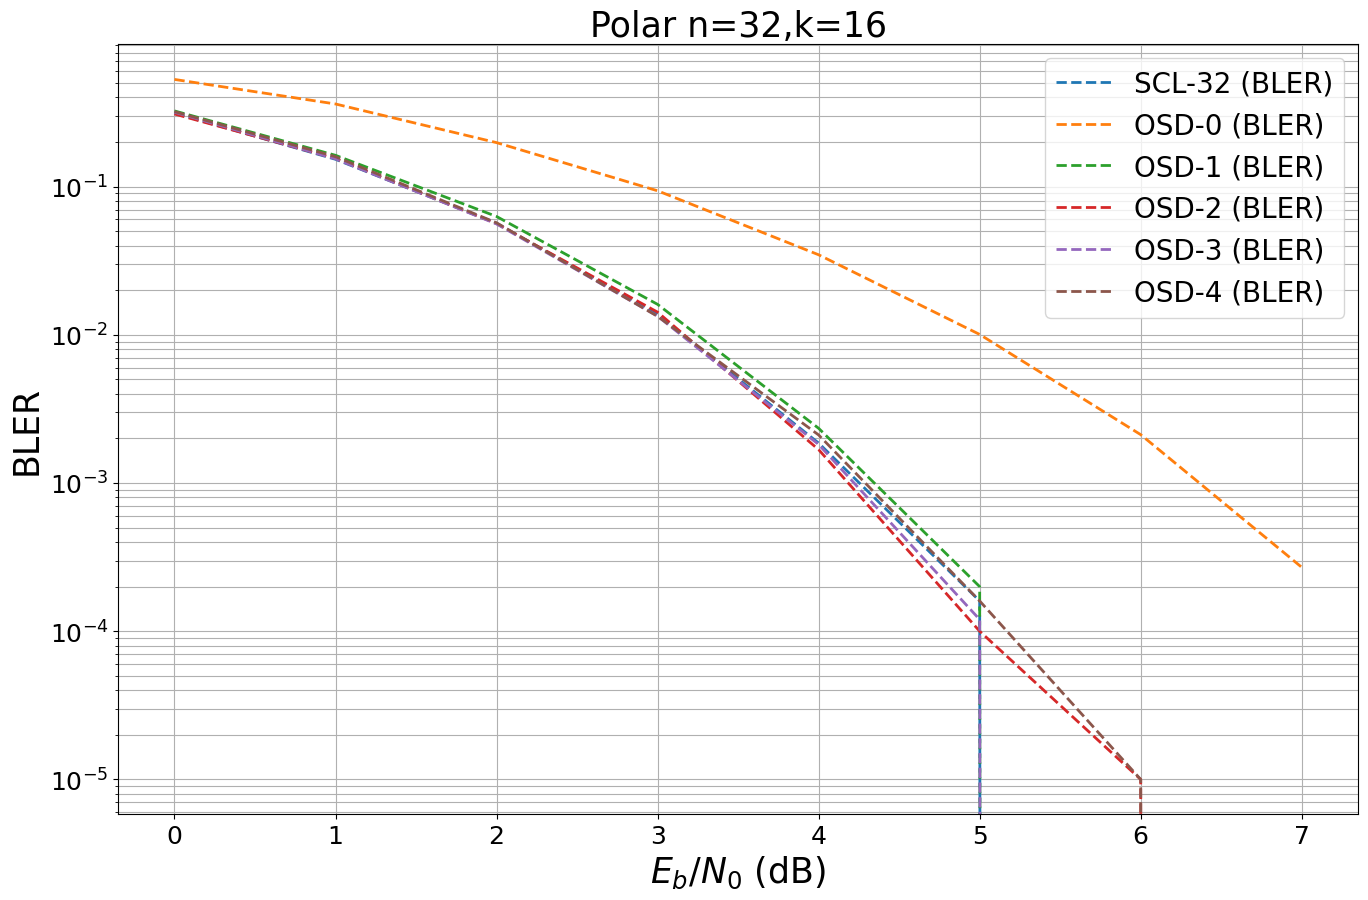

In [8]:
# very short polar codes

ebno_db = np.linspace(0, 7, 8) # sim SNR range

k = 16
n = 32
f, _ = generate_5g_ranking(k, n)
# init components
enc = PolarEncoder(f, n)
dec = OSDecoder(encoder=enc, t=4)
model = System_Model(enc, dec, cw_estimate=True)

dec_ref = PolarSCLDecoder(f, n, list_size=32)
model_ref = System_Model(enc, dec_ref, cw_estimate=False)


# and run simulation
ber_plot = PlotBER(f"Polar n={n},k={k}")

# reference with Polar SCL
ber_plot.simulate(model_ref,
                  ebno_dbs=ebno_db,
                  legend=f"SCL-{dec_ref.list_size}",
                  max_mc_iter=100,
                  num_target_block_errors=2000,
                  batch_size=1000,
                  soft_estimates=False,
                  early_stop=True,
                  show_fig=False,
                  add_bler=True,
                  forward_keyboard_interrupt=True);

# sweep over t
for t in range(5):
    dec = OSDecoder(encoder=enc, t=t)
    model = System_Model(enc, dec, cw_estimate=True)
    ber_plot.simulate(model,
                    ebno_dbs=ebno_db,
                    legend=f"OSD-{dec.t}",
                    max_mc_iter=100,
                    num_target_block_errors=2000,
                    batch_size=1000,
                    soft_estimates=False,
                    early_stop=True,
                    show_fig=False,
                    add_bler=True,
                    forward_keyboard_interrupt=True);


# ber is not comparable (u_hat vs. c_hat)
ber_plot(show_ber=False)


## Evaluate Convolutional Codes & Viterbi

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.1259e-01 | 9.0867e-01 |       40532 |      360000 |         2726 |        3000 |         2.3 |reached target block errors
      1.0 | 4.4856e-02 | 6.6800e-01 |       16148 |      360000 |         2004 |        3000 |         0.0 |reached target block errors
      2.0 | 1.2927e-02 | 3.2186e-01 |       10859 |      840000 |         2253 |        7000 |         0.1 |reached target block errors
      3.0 | 2.7785e-03 | 1.1132e-01 |        6335 |     2280000 |         2115 |       19000 |         0.3 |reached target block errors
      4.0 | 6.1042e-04 | 3.5946e-02 |        4102 |     6720000 |         2013 |       56000 |         0.8 |reached target block errors
      5.0 | 1.5108e-04 | 1.1790e-02 |        1813 |    12000000 |

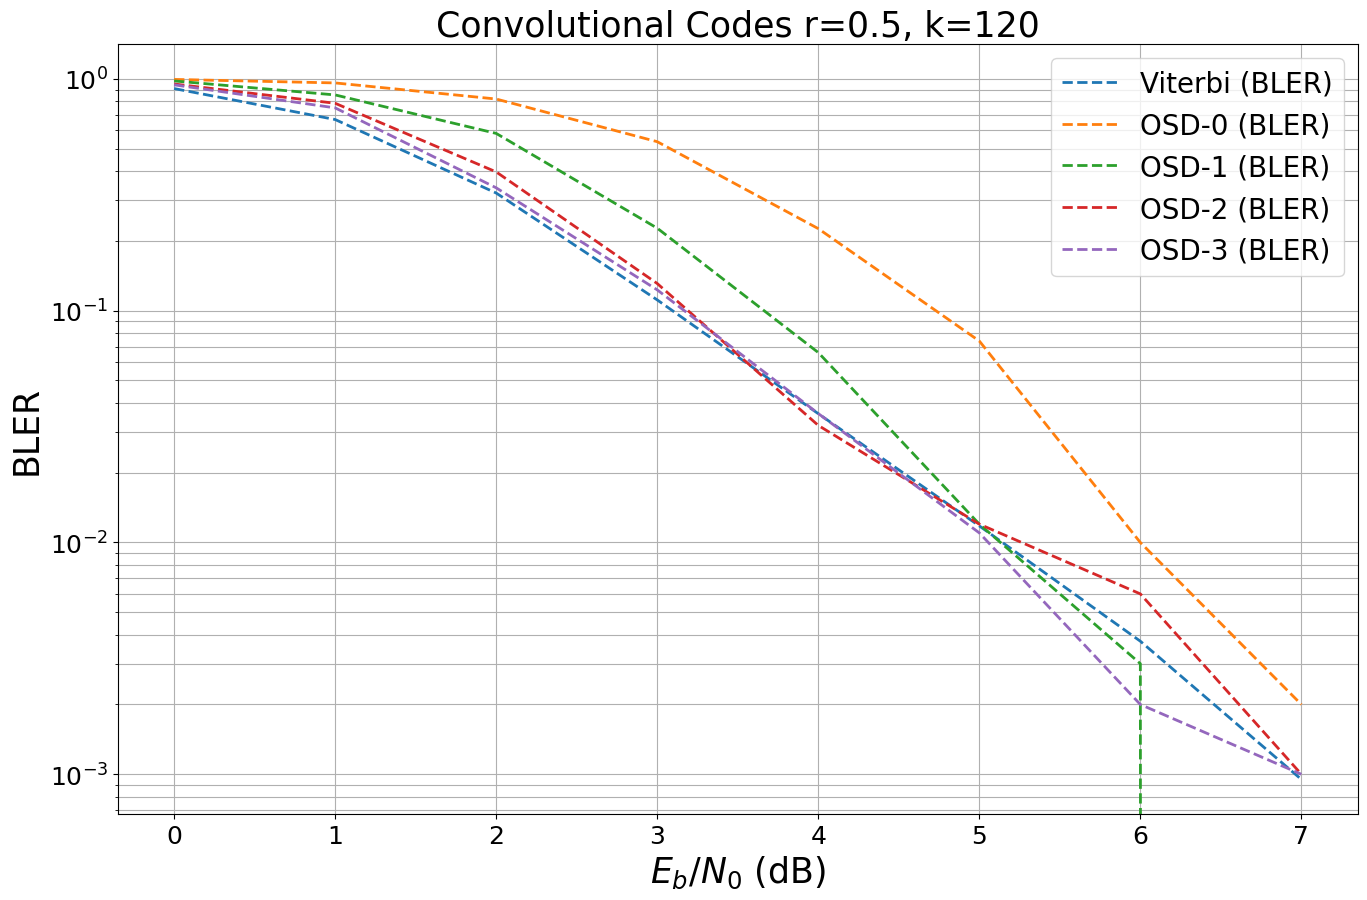

In [9]:
# very short polar codes

ebno_db = np.linspace(0, 7, 8) # sim SNR range

k = 120
constraint_length = 5
r = 0.5

# init components
enc = ConvEncoder(rate=r, constraint_length=constraint_length)
# init encoder
enc(tf.zeros((1, k)))

dec_ref = ViterbiDecoder(rate=r, constraint_length=constraint_length)
model_ref = System_Model(enc, dec_ref, cw_estimate=False)


# and run simulation
ber_plot = PlotBER(f"Convolutional Codes r={r}, k={k}")

# reference with Polar SCL
ber_plot.simulate(model_ref,
                  ebno_dbs=ebno_db,
                  legend=f"Viterbi",
                  max_mc_iter=100,
                  num_target_block_errors=2000,
                  batch_size=1000,
                  soft_estimates=False,
                  early_stop=True,
                  show_fig=False,
                  add_bler=True,
                  forward_keyboard_interrupt=True);

# sweep over t
for t in range(4):
    dec = OSDecoder(encoder=enc, t=t)
    model = System_Model(enc, dec, cw_estimate=True)
    ber_plot.simulate(model,
                    ebno_dbs=ebno_db,
                    legend=f"OSD-{dec.t}",
                    max_mc_iter=100,
                    num_target_block_errors=2000,
                    batch_size=10,
                    soft_estimates=False,
                    early_stop=True,
                    show_fig=False,
                    add_bler=True,
                    forward_keyboard_interrupt=True);


# ber is not comparable (u_hat vs. c_hat)
ber_plot(show_ber=False)
